In [181]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

# Ethnicity correlation

In [182]:
data_success = pd.read_csv('clean_data_success.csv')
data_bechdel = pd.read_csv('clean_data_bechdel.csv')
data_character = pd.read_csv('clean_data_character.csv')
data_original = pd.read_csv('clean_data_original.csv')
ethnicity_df = pd.read_csv('ethnicity_labels.csv')

Create a numerical categorical variable associated with the different ethnicities

In [183]:
ethnicity_df['ethnic_cat'] = ethnicity_df.index
data_character = pd.merge(data_character, ethnicity_df[['ethnicity_ID', 'ethnic_cat']], on='ethnicity_ID', how='left')

Add a line with the ratio of Women within the main actors in the films

In [184]:
data_success['num_actors'] = data_success['Movie_ID'].map(data_character.groupby('Movie_ID')['Actor_ID'].nunique())
data_success['num_women'] = data_success['Movie_ID'].map(data_character[data_character['actor_gender']=='F'].groupby('Movie_ID')['Actor_ID'].nunique())
data_success['ratio_W/M'] = data_success['num_women']/data_success['num_actors']

In [185]:
women_data = data_character[data_character['actor_gender']=='F'].copy()
men_data = data_character[data_character['actor_gender']=='M'].copy()

We will only consider the ethnicities for which we have a minimum of 30 different actors. Else, it doesn't seem to be enough to draw any conclusions.

In [186]:
low_count_ethnicities = ethnicity_df.loc[ethnicity_df['count'] < 30, 'ethnic_cat'].tolist()
women_data_ethnicity = women_data.copy()
women_data_ethnicity['ethnic_cat'] = women_data['ethnic_cat'].apply(lambda x: pd.NA if x in low_count_ethnicities else x)

We will keep only movies with at least 4 actors and 10% actress since we are focusing on actress.

In [187]:
valid_mask = (data_success['ratio_W/M'] >= 0.1) & (data_success['num_actors'] > 4)
movies_women = data_success[valid_mask].copy()

In [188]:
analysis = pd.merge(
                        women_data_ethnicity[['actor_age_movie_released', 'Movie_ID', 'actor_name', 'ethnic_cat', 'actor_height']],
                        movies_women.dropna(subset=['SuccessMetric'])[['title', 'SuccessMetric', 'Movie_ID', 'ratio_W/M', 'rating']],
                        on='Movie_ID',
                        how = 'inner'
                        )

mean_women_data = analysis.groupby('Movie_ID').agg(
                                                    mean_age=('actor_age_movie_released', 'mean'),
                                                    num_women=('actor_age_movie_released', 'size'),
                                                    title=('title', 'first'),
                                                    SuccessMetric=('SuccessMetric', 'first'),
                                                    ratio_W_M = ('ratio_W/M', 'first'),
                                                    ethnicities = ('ethnic_cat', lambda x: [eth for eth in x if pd.notna(eth)]),
                                                    avg_height = ('actor_height', 'mean'),
                                                    Rating = ('rating', 'first')
                                                ).reset_index()
print(f"The total number of movies with a success metrics is {mean_women_data.shape[0]}.")

The total number of movies with a success metrics is 3277.


We will remove 

In [189]:
ethnicity_counts = pd.Series([eth for sublist in mean_women_data['ethnicities'] for eth in sublist if pd.notna(eth)]).value_counts()
valid_ethnicities = ethnicity_counts[ethnicity_counts >= 30].index

mean_women_data['ethnicities'] = mean_women_data['ethnicities'].apply(
    lambda eth_list: [eth for eth in eth_list if eth in valid_ethnicities]
)

mean_women_data = mean_women_data[mean_women_data['ethnicities'].apply(len) > 0]

# Display the updated DataFrame
print(mean_women_data.shape)


(2149, 9)


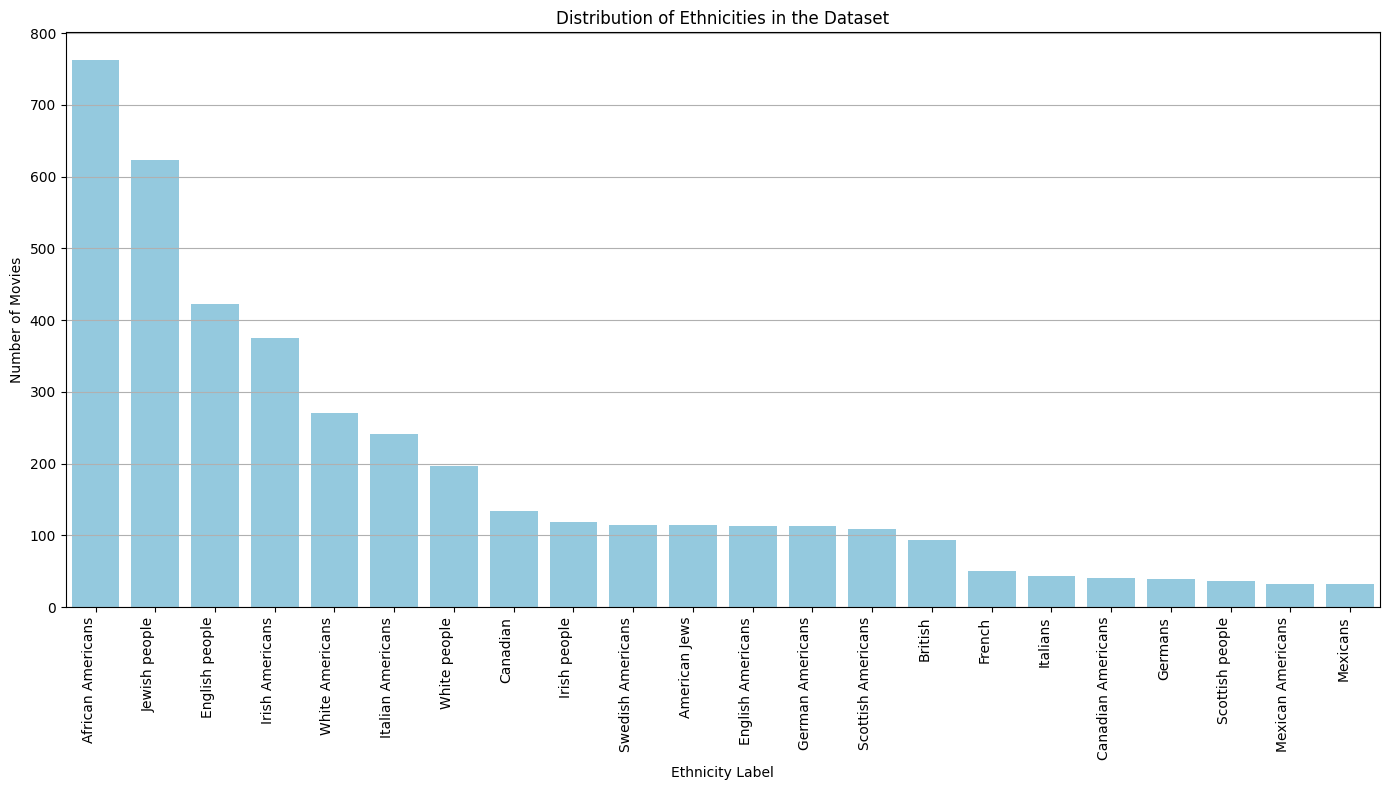

In [190]:

ethnicity_counts = pd.Series([eth for sublist in mean_women_data['ethnicities'] for eth in sublist if pd.notna(eth)])
ethnicity_distribution = ethnicity_counts.value_counts().reset_index()
ethnicity_distribution.columns = ['ethnic_cat', 'count']

ethnicity_distribution = pd.merge(
    ethnicity_distribution,
    ethnicity_df[['ethnic_cat', 'ethnicity_label']],
    on='ethnic_cat',
    how='left'
)

ethnicity_distribution = ethnicity_distribution.sort_values(by='count', ascending=False)

plt.figure(figsize=(14, 8))
sns.barplot(x='ethnicity_label', y='count', data=ethnicity_distribution, color='skyblue')
plt.title("Distribution of Ethnicities in the Dataset")
plt.xlabel("Ethnicity Label")
plt.ylabel("Number of Movies")
plt.xticks(rotation=90, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


The distribution of the data on the different ethnicities is not equally distributed at all. We will have to be carefull with this.

# Establish relationship between ethnicities and SuccessMetric

We looked at the difference of mean success metrics between movies containing at least one actress from an ethnicity compared to all other movies. Then we performed a t-test using equal_var=False to compensate the fact that the distribution is not even for every ethnicity.

In [196]:
results_list = []

# Get the list of unique ethnic categories
all_ethnic_cats = pd.Series([eth for sublist in mean_women_data['ethnicities'] for eth in sublist if pd.notna(eth)]).unique()


for ethnic_cat in all_ethnic_cats:
    # Filter out movies that include this ethnic category
    movies_with_ethnic_cat = mean_women_data[mean_women_data['ethnicities'].apply(lambda x: isinstance(x, list) and ethnic_cat in x)]
    movies_without_ethnic_cat = mean_women_data[mean_women_data['ethnicities'].apply(lambda x: isinstance(x, list) and ethnic_cat not in x)]

    if len(movies_with_ethnic_cat) < 2 or len(movies_without_ethnic_cat) < 2:
        print(f"Not enough movies for comparison for ethnicity: {ethnic_cat}")
        continue
    
    # Calculate mean success scores on each group
    mean_with = movies_with_ethnic_cat['SuccessMetric'].mean()
    mean_without = movies_without_ethnic_cat['SuccessMetric'].mean()
    
    # Check for low variance or insufficient unique values
    if movies_with_ethnic_cat['SuccessMetric'].nunique() < 2 or movies_without_ethnic_cat['SuccessMetric'].nunique() < 2:
        t_stat, p_value = np.nan, np.nan
    else:
        t_stat, p_value = ttest_ind(
            movies_with_ethnic_cat['SuccessMetric'].dropna(),
            movies_without_ethnic_cat['SuccessMetric'].dropna(),
            equal_var=False
        )
    
    results_list.append({
        'ethnic_cat': ethnic_cat,
        'nb_movies_with':  len(movies_with_ethnic_cat),
        'nb_movies_without': len(movies_without_ethnic_cat),
        'mean_diff': mean_with - mean_without,
        'mean_with_ethnic_cat': mean_with,
        'mean_without_ethnic_cat': mean_without,
        't_stat': t_stat,
        'p_value': p_value
    })


results_df = pd.DataFrame(results_list)
results_df = results_df.sort_values(by='p_value')


In [199]:
results_df.head(8)

,ethnic_cat,nb_movies_with,nb_movies_without,mean_diff,mean_with_ethnic_cat,mean_without_ethnic_cat,t_stat,p_value
1,24.0,314,1835,0.062532,0.569987,0.507455,4.377817,0.000015
8,113.0,35,2114,0.154195,0.668275,0.514081,4.369022,0.000104
7,7.0,111,2038,-0.052965,0.466363,0.519328,-2.158326,0.032895
4,75.0,86,2063,0.055050,0.569439,0.514389,2.123703,0.036383
5,3.0,543,1606,-0.019150,0.502281,0.521431,-1.716443,0.086399
2,48.0,245,1904,0.025585,0.539260,0.513675,1.695429,0.090978
6,25.0,115,2034,0.037193,0.551795,0.514602,1.657725,0.099847
10,0.0,125,2024,-0.033394,0.485141,0.518534,-1.654177,0.100306


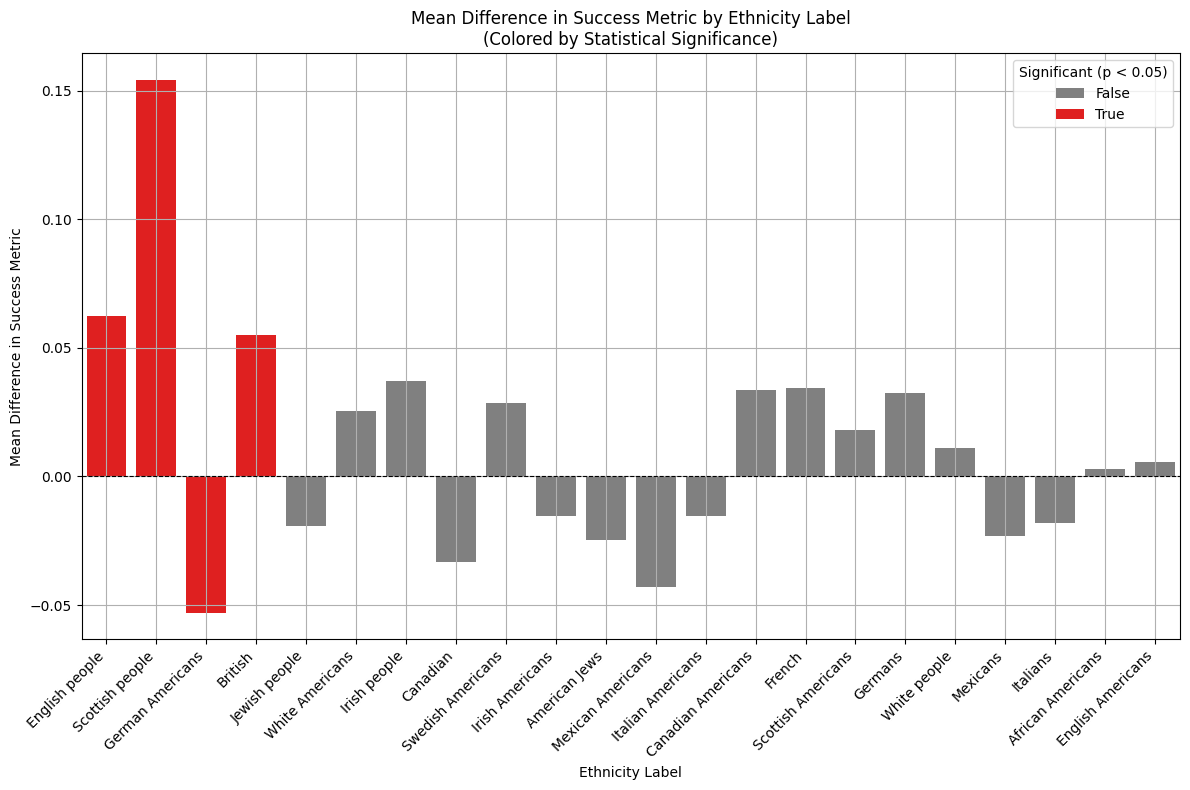

In [201]:

merged_df = pd.merge(results_df, ethnicity_df[['ethnic_cat', 'ethnicity_label']], on='ethnic_cat', how='left')
merged_df_clean = merged_df.dropna(subset=['p_value'])
merged_df_clean['Significant'] = merged_df_clean['p_value'] < 0.05

plt.figure(figsize=(12, 8))
sns.barplot(
    data=merged_df_clean,
    x='ethnicity_label', y='mean_diff',
    hue='Significant',
    palette={True: 'red', False: 'gray'}
)

plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.xlabel("Ethnicity Label")
plt.ylabel("Mean Difference in Success Metric")
plt.title("Mean Difference in Success Metric by Ethnicity Label\n(Colored by Statistical Significance)")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Significant (p < 0.05)")
plt.grid(True)
plt.tight_layout()
plt.show()
